In [215]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
import joblib
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [216]:
def preprocess(raw_data):
    
    raw_data.iloc[:,   9:189] = raw_data.iloc[:, 9:189].div(raw_data['weight'], axis=0) #normalize all the V colums to weight
    raw_data.iloc[:, 191:371] = raw_data.iloc[:, 191:371].div(raw_data['weight'], axis=0) #normalize all the V colums to weight

    raw_data['gait']=1 #change all string 'walk' to a number 1
    raw_data['Gait']=1 #change all string 'trot' to a number 1

    raw_data.loc[raw_data['speed'] .isin(['Not able to walk', 'no data','no valid trials', np.nan]), raw_data.columns[7:189]] = 0    #impute all the 'not able' column with 0
    raw_data.loc[raw_data['Speed'] .isin(['Not able to trot', 'no data', 'no valid trials', np.nan]), raw_data.columns[189:371]] = 0  #impute all the 'not able' column with 0

    #drop object column, which is irrevelant colums to our modles
    raw_data.drop(['dob','forceplate_date'], axis=1, inplace=True)

    raw_data['speed'] = raw_data['speed'].astype(float)
    raw_data['Speed'] = raw_data['Speed'].astype(float)

#     raw_data.fillna(raw_data.mean(), inplace=True)
    
    return raw_data

In [217]:
# missing value imputing, using the same mean value from training dataset
loca='LF'
raw_data_train = pd.read_csv('raw_data/'+loca+'_train.csv')
raw_data_val = pd.read_csv('raw_data/'+loca+'_val.csv')

data_train = preprocess(raw_data_train)
data_val = preprocess(raw_data_val)

impute_value = data_train.mean()

data_train.fillna(impute_value, inplace=True)
data_val.fillna(impute_value, inplace=True)

In [218]:
X_train = data_train.drop([loca, 'id'], axis=1)
# X = raw_data.drop(['LF', 'id','gait','Gait'], axis=1)
y_train = data_train[loca]

X_val = data_val.drop([loca, 'id'], axis=1)
# X = raw_data.drop(['LF', 'id','gait','Gait'], axis=1)
y_val = data_val[loca]

# X_train.to_csv('train_processed_simple_imputed.csv', index=False)
# X_val.to_csv('val_processed_simple_imputed.csv', index=False)

## Logistic Regression

In [219]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)
y_pred_LR = model_LR.predict(X_val)
accuracy_LR = accuracy_score(y_val, y_pred_LR)
print(f"Accuracy: {accuracy_LR}")

Accuracy: 0.8918918918918919


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Kernalized SVM

In [220]:
model_SVM = svm.SVC(kernel='rbf')
model_SVM.fit(X_train,y_train)
y_pred_SVM = model_SVM.predict(X_val)
print(accuracy_score(y_val, y_pred_SVM))

0.8648648648648649


## Random Forest

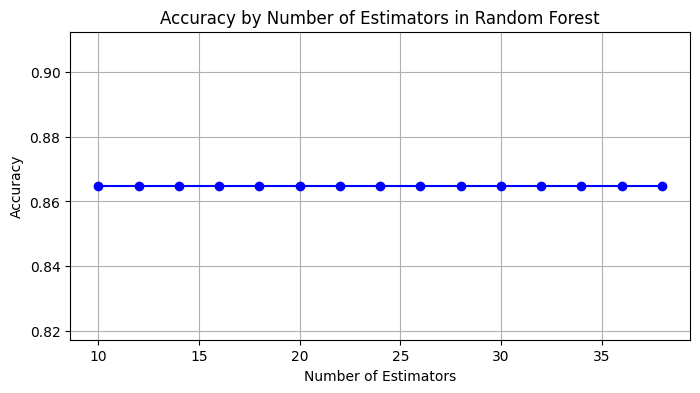

[[32  0]
 [ 5  0]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        32
           1       0.00      0.00      0.00         5

    accuracy                           0.86        37
   macro avg       0.43      0.50      0.46        37
weighted avg       0.75      0.86      0.80        37

0.8648648648648649


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [221]:
estimator_range = range(10, 40, 2)
accuracy_RF=[]
random_state = 1

for estimator_size in estimator_range:
#     print(estimator_size)
    model_RF=RandomForestClassifier(n_estimators=estimator_size)
    model_RF.fit(X_train, y_train)
    y_pred_RF = model_RF.predict(X_val)
    accuacy=accuracy_score(y_val, y_pred_RF)
#     print(accuacy)
    accuracy_RF.append(accuacy)

plt.figure(figsize=(8, 4))
plt.plot(estimator_range, accuracy_RF, marker='o', linestyle='-', color='b')
plt.title('Accuracy by Number of Estimators in Random Forest')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

print(confusion_matrix(y_val, y_pred_RF))
print(classification_report(y_val, y_pred_RF))
print(accuracy_score(y_val, y_pred_RF))

## GBM

In [222]:
gbm_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Fit the model
gbm_clf.fit(X_train, y_train)

# Predict on the test data
y_pred = gbm_clf.predict(X_val)

# Print the accuracy
print('Accuracy: ', accuracy_score(y_val, y_pred))

Accuracy:  0.8918918918918919


## GBM Search

In [223]:
best_acc=0
progress=0
for n_estimators in [100, 200, 300, 400]:
    for learning_rate in [0.001,0.01, 0.1, 0.3]:
        for max_depth in [1, 2, 3, 4]:
            progress+=1
            print(f'Progress:{progress}/{4*4*4}')
            gbm_clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
            gbm_clf.fit(X_train, y_train)
            y_pred = gbm_clf.predict(X_val)
            if accuracy_score(y_val, y_pred)>= best_acc:
                best_acc=accuracy_score(y_val, y_pred)
                best_param=[n_estimators,learning_rate,max_depth]
                print(f'Best parameters: n_estimators: {n_estimators},learning_rate:{learning_rate}, max_depth:{max_depth}')
                print(f'best_acc:{best_acc}')
# Print the accuracy

Progress:1/64
Best parameters: n_estimators: 100,learning_rate:0.001, max_depth:1
best_acc:0.8648648648648649
Progress:2/64
Best parameters: n_estimators: 100,learning_rate:0.001, max_depth:2
best_acc:0.8648648648648649
Progress:3/64
Best parameters: n_estimators: 100,learning_rate:0.001, max_depth:3
best_acc:0.8648648648648649
Progress:4/64
Best parameters: n_estimators: 100,learning_rate:0.001, max_depth:4
best_acc:0.8648648648648649
Progress:5/64
Best parameters: n_estimators: 100,learning_rate:0.01, max_depth:1
best_acc:0.8648648648648649
Progress:6/64
Best parameters: n_estimators: 100,learning_rate:0.01, max_depth:2
best_acc:0.8648648648648649
Progress:7/64
Best parameters: n_estimators: 100,learning_rate:0.01, max_depth:3
best_acc:0.8918918918918919
Progress:8/64
Progress:9/64
Progress:10/64
Progress:11/64
Best parameters: n_estimators: 100,learning_rate:0.1, max_depth:3
best_acc:0.8918918918918919
Progress:12/64
Progress:13/64
Progress:14/64
Best parameters: n_estimators: 100,l

## XGBoost Search (imputed)

In [224]:
best_acc=0
progress=0
for max_depth in [1,3,6,9]:
    for learning_rate in [0.01, 0.1,0.3,0.6]:
        for n_estimators in [100,200,300,400]:
            progress+=1
            print(f'Progress:{progress}/{4*4*4}')
            xgb_clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators)
            xgb_clf.fit(X_train, y_train)
            y_pred = xgb_clf.predict(X_val)
            if accuracy_score(y_val, y_pred)>= best_acc:
                best_acc=accuracy_score(y_val, y_pred)
                best_param=[n_estimators,learning_rate,max_depth]
                print(f'Best parameters: n_estimators: {n_estimators},learning_rate:{learning_rate}, max_depth:{max_depth}')
                print(f'best_acc:{best_acc}')
            

Progress:1/64
Best parameters: n_estimators: 100,learning_rate:0.01, max_depth:1
best_acc:0.8648648648648649
Progress:2/64
Best parameters: n_estimators: 200,learning_rate:0.01, max_depth:1
best_acc:0.8648648648648649
Progress:3/64
Best parameters: n_estimators: 300,learning_rate:0.01, max_depth:1
best_acc:0.8648648648648649
Progress:4/64
Best parameters: n_estimators: 400,learning_rate:0.01, max_depth:1
best_acc:0.8648648648648649
Progress:5/64
Best parameters: n_estimators: 100,learning_rate:0.1, max_depth:1
best_acc:0.8648648648648649
Progress:6/64
Best parameters: n_estimators: 200,learning_rate:0.1, max_depth:1
best_acc:0.8648648648648649
Progress:7/64
Best parameters: n_estimators: 300,learning_rate:0.1, max_depth:1
best_acc:0.8648648648648649
Progress:8/64
Best parameters: n_estimators: 400,learning_rate:0.1, max_depth:1
best_acc:0.8648648648648649
Progress:9/64
Best parameters: n_estimators: 100,learning_rate:0.3, max_depth:1
best_acc:0.8648648648648649
Progress:10/64
Best para